In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from post_processing import *
from utils import *
# from fast_macro_f1_func import *
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore")

In [2]:
# chris clean dataset
df_train = pd.read_csv("../input/train_clean.csv")
df_test = pd.read_csv("../input/test_clean.csv")

df_train["local_time"] = df_train.time % 50
df_train.loc[df_train.local_time == 0.0000, "local_time"] = 50

df_test["local_time"] = df_test.time % 50
df_test.loc[df_test.local_time == 0.0000, "local_time"] = 50

df_test["mini_local_time"] = df_test.time % 10
df_test.loc[df_test.local_time == 0.0000, "mini_local_time"] = 10

BATCH_SIZE = 500000

# train
for batch_i in range(10):
    df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    df_train.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    df_train.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    df_train.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    df_train.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5
# test
for batch_i in range(4):
    df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    df_test.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    df_test.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    df_test.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    df_test.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5
    
df_train = df_train.drop(df_train[(df_train.batch.isin([8]))].index)


In [3]:
# channel 0 - batch 1
channel_0_batch_1 = df_train[(df_train.batch == 1) & (df_train.open_channels == 0)]
channel_0_batch_1_threshold = channel_0_batch_1.signal.quantile(0.99999)
channel_0_batch_1.loc[channel_0_batch_1.signal > channel_0_batch_1_threshold, "signal"] = channel_0_batch_1_threshold
df_train.loc[(df_train.batch == 1) & (df_train.open_channels == 0), "signal"] = channel_0_batch_1.signal

In [4]:
df_train.loc[(df_train.batch.isin([5, 10])), "signal"] += 2.726
df_test.loc[(df_test.batch.isin([2])) & (df_test.mini_batch.isin([1, 3])),
            "signal"] += 2.726

In [5]:
# df_train = pd.read_pickle('../features/train_v2.pkl')
# df_test = pd.read_pickle('../features/test_v2.pkl')

sub = pd.read_csv("../input/sample_submission.csv")
sub['time'] = [format(sub.time.values[x], '.4f') for x in range(2000000)]
TARGET = "open_channels"

print(df_train.shape, df_test.shape, sub.shape)
df_train.head()

(4500000, 6) (2000000, 6) (2000000, 2)


,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1.0,1.0
1,0.0002,-2.8557,0,0.0002,1.0,1.0
2,0.0003,-2.4074,0,0.0003,1.0,1.0
3,0.0004,-3.1404,0,0.0004,1.0,1.0
4,0.0005,-3.1525,0,0.0005,1.0,1.0


In [6]:
shift = 1

def fe(df):
    
    for shift_val in range(1, shift + 1):
    
        df[f'shift+{shift_val}'] = df.groupby(['batch']).shift(shift_val)['signal']
#         df[f'shift_{shift_val}'] = df.groupby(['batch']).shift(-shift_val)['signal']
        
#         df[f'diff+{shift_val}'] = df[f'shift+{shift_val}'] - df['signal']
#         df[f'diff_{shift_val}'] = df[f'shift_{shift_val}'] - df['signal']
        
#         df[f'add+{shift_val}'] = df[f'shift+{shift_val}'] + df['signal']
#         df[f'add_{shift_val}'] = df[f'shift_{shift_val}'] + df['signal']
        
#         df[f'mul+{shift_val}'] = df[f'shift+{shift_val}'] * df['signal']
#         df[f'mul_{shift_val}'] = df[f'shift_{shift_val}'] * df['signal']

    return df

def fe_test(df):
    
    for shift_val in range(1, shift + 1):
    
        df[f'shift+{shift_val}'] = df.groupby(['batch', 'mini_batch']).shift(shift_val)['signal']
        df[f'shift_{shift_val}'] = df.groupby(['batch', 'mini_batch']).shift(-shift_val)['signal']

#         df[f'diff+{shift_val}'] = df[f'shift+{shift_val}'] - df['signal']
#         df[f'diff_{shift_val}'] = df[f'shift_{shift_val}'] - df['signal']
        
#         df[f'add+{shift_val}'] = df[f'shift+{shift_val}'] + df['signal']
#         df[f'add_{shift_val}'] = df[f'shift_{shift_val}'] + df['signal']

    return df

print("feature engineering on training data ...")
df_train = fe(df_train)
print("feature engineering on testing data ...")
df_test = fe_test(df_test) # should group mini-batch ***

df_train.dropna(inplace=True)
df_test.fillna(method = "bfill", inplace=True)
df_test.fillna(method = "ffill", inplace=True)

print("feature engineering is done ...")

feature engineering on training data ...
feature engineering on testing data ...
feature engineering is done ...


In [7]:
color_list = [
    "b", "g", "r", "c", "m", "k", "y", '#0000FF', '#8A2BE2', '#A52A2A',
    '#DEB887', '#5F9EA0'
]

# drop useless features
drop_features = [
    "time",
    "open_channels",
    "local_time",
    "batch",
    "mini_batch",
    "oof",
]
all_features = [col for col in df_train.columns if col not in drop_features]
D = len(all_features)

print("train/test shape is:", df_train.shape, df_test.shape)
print("features used # is", len(all_features))
df_train[all_features].head()

train/test shape is: (4499991, 7) (2000000, 8)
features used # is 2


,signal,shift+1
1,-2.8557,-2.7600
2,-2.4074,-2.8557
3,-3.1404,-2.4074
4,-3.1525,-3.1404
5,-2.6418,-3.1525


### model 1 - batch 1&2

In [16]:
# model 1: batch 1&2
BATCH_GROUP_1 = [6]
df_train_1 = df_train[df_train.batch.isin(BATCH_GROUP_1)]

In [20]:
df_train_1_sam = df_train_1.sample(50000)
df_train_1_sam = df_train_1_sam[df_train_1_sam.open_channels == 4]

In [21]:
df_train_1_embedded = TSNE(n_components=2).fit_transform(df_train_1_sam[all_features])

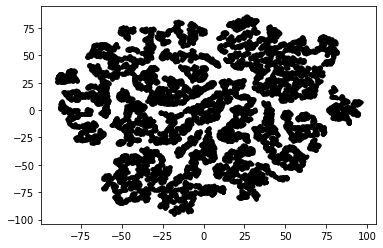

In [22]:
plt.plot(df_train_1_embedded[df_train_1_sam.open_channels == 0][:, 0],
         df_train_1_embedded[df_train_1_sam.open_channels == 0][:, 1], ".b")

plt.plot(df_train_1_embedded[df_train_1_sam.open_channels == 1][:, 0],
         df_train_1_embedded[df_train_1_sam.open_channels == 1][:, 1], ".r")

plt.plot(df_train_1_embedded[df_train_1_sam.open_channels == 2][:, 0],
         df_train_1_embedded[df_train_1_sam.open_channels == 2][:, 1], ".m")

plt.plot(df_train_1_embedded[df_train_1_sam.open_channels == 3][:, 0],
         df_train_1_embedded[df_train_1_sam.open_channels == 3][:, 1], ".g")

plt.plot(df_train_1_embedded[df_train_1_sam.open_channels == 4][:, 0],
         df_train_1_embedded[df_train_1_sam.open_channels == 4][:, 1], ".k")

plt.plot(df_train_1_embedded[df_train_1_sam.open_channels == 5][:, 0],
         df_train_1_embedded[df_train_1_sam.open_channels == 5][:, 1], ".c")